# Modified IQAE tests

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from algorithms import NoQuantumIterativeAmplitudeEstimation
from operators import *

In [2]:
# for setting a single amplitude, below automates this for arbirtrary numbers of amplitudes
n = 4
N = 2**n
k = N//2
marked = sample(range(N), k)

In [3]:
# Define the estimation problem and oracle function
def make_problems(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    problem2 = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem, problem2

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 100

## Compare Modified IQAE to No-Quantum IQAE

In [5]:
# parameters for IQAE

# amplitudes
n = 4
k = 2**n

# epsilons
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]

# other
alpha = 0.05
confint_method = 'chernoff'
verbose = False

a: 0/16 = 0.0
Modified IAE estimations: [3.632618051684471e-05, 1.2084037824424888e-06, 9.189148541627664e-09, 1.2839876839341917e-10, 1.0212821016182717e-12]
Original IAE estimations: [4.5459085893367654e-05, 1.9947285420675235e-06, 4.923525110072622e-09, 6.235463877894556e-11, 5.911852271772893e-13]
Modified IAE total queries: 46278200
Original IAE total queries: 69987500
Modified IAE epsilons: [3.632618051684471e-05, 1.2084037824424888e-06, 9.189148541627664e-09, 1.2839876839341917e-10, 1.0212821016182717e-12]
Original IAE epsilons: [4.5459085893367654e-05, 1.9947285420675235e-06, 4.923525110072622e-09, 6.235463877894556e-11, 5.911852271772893e-13]


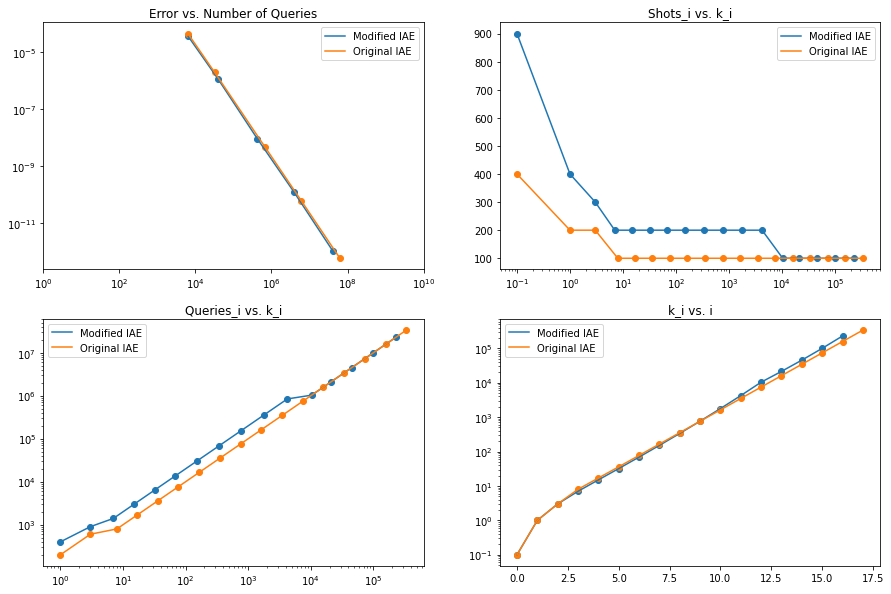

a: 1/16 = 0.0625
Modified IAE estimations: [0.0629415183187832, 0.06251085669239777, 0.061460766952551545, 0.06250027150660387, 0.06249994499529057]
Original IAE estimations: [0.062205172618956694, 0.06255269758078541, 0.06250385851507856, 0.06249980211675926, 0.06250002349002579]
Modified IAE total queries: 89594300
Original IAE total queries: 101141600
Modified IAE epsilons: [0.003024913160945983, 0.0002877678099583586, 3.989823918700702e-05, 3.981335560326177e-06, 3.093790554367648e-07]
Original IAE epsilons: [0.00439698438130957, 0.0004673372751127572, 4.3004553630324877e-05, 3.3020238904384047e-06, 3.43180916718977e-07]


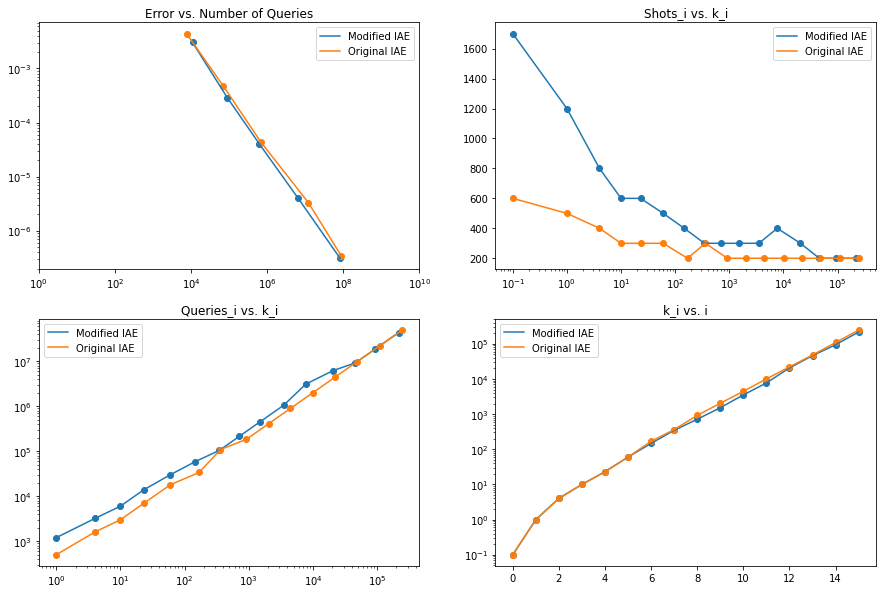

a: 2/16 = 0.125
Modified IAE estimations: [0.1264667950518751, 0.12490754154266895, 0.12498290844666998, 0.12499842181649706, 0.12499995255357148]
Original IAE estimations: [0.12393895118683035, 0.1251496430775154, 0.12141026640108159, 0.12499808155421072, 0.12499995715181589]
Modified IAE total queries: 80099800
Original IAE total queries: 93675900
Modified IAE epsilons: [0.006535407575836927, 0.0006120362209175723, 5.753295904678546e-05, 4.633727636475793e-06, 5.069373971572366e-07]
Original IAE epsilons: [0.005365342090808155, 0.0005151950169884553, 3.664113479000253e-05, 5.815484584219266e-06, 5.915110502727194e-07]


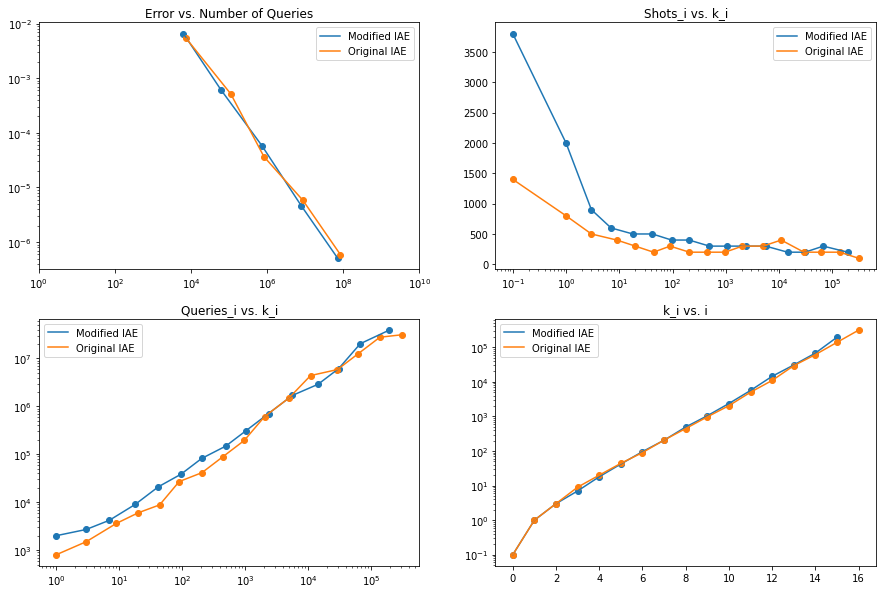

a: 3/16 = 0.1875
Modified IAE estimations: [0.18851999852769086, 0.18756962214147285, 0.187499273712847, 0.1666199343255267, 0.18680342439109807]
Original IAE estimations: [0.18643783483184426, 0.18755812255390175, 0.1875051684004742, 0.18750197825216486, 0.18750002410982874]
Modified IAE total queries: 66723400
Original IAE total queries: 100878500
Modified IAE epsilons: [0.004846626330450965, 0.0007041158451630558, 5.459259337911582e-05, 6.5147593726472275e-06, 6.080418522569353e-07]
Original IAE epsilons: [0.006336635183548933, 0.0007202128619017423, 7.31387027144842e-05, 6.1505661663463496e-06, 5.209680591644616e-07]


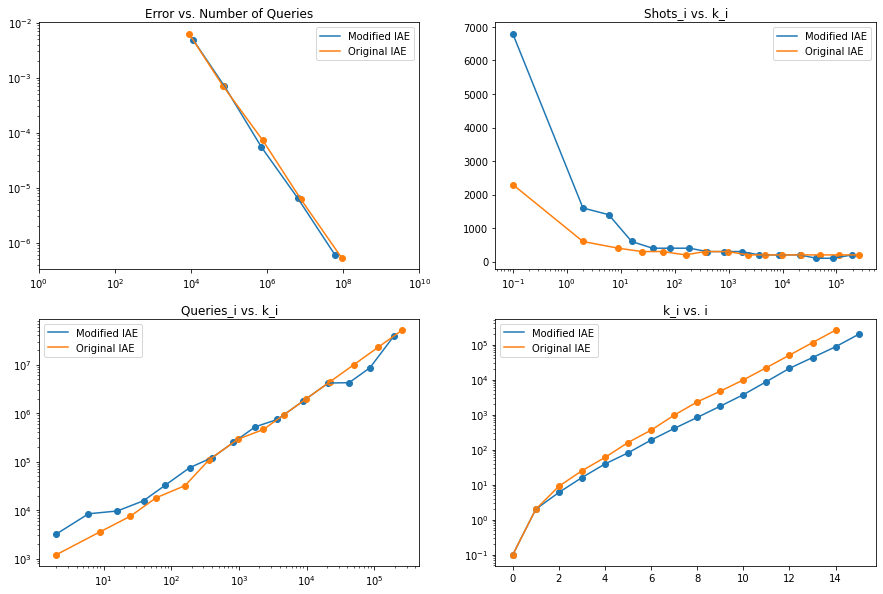

In [ ]:
# stats recording
iae_epsilon = []
iae_nshots = []
miae_epsilon = []
miae_nshots = []

wins = matches = 0

tdelta = 0

ki = 0
while ki <= k:
    
    # setup problems with specified N,k
    N = 2**n
    marked = sample(range(N), ki)
    problem, problem2 = make_problems(n, marked)
    
    # execute experiments for each power
    miae_results = [] 
    iae_results = []
    
    for i, epsilon in enumerate(epsilons):
        if verbose:
            print('ε:',epsilon)
            
        MIAE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                    alpha=alpha, 
                                                    confint_method=confint_method, 
                                                    quantum_instance=aer_sim)
        
        IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                    alpha=alpha, 
                                                    confint_method=confint_method, 
                                                    quantum_instance=aer_sim)
        
        exprs = ['Modified IAE', 'Original IAE']
        
        # configure the number of shots this way and pray that it works
        MIAE._quantum_instance._run_config.shots = shots
        IAE._quantum_instance._run_config.shots = shots
        
        # for recording intermediate algo results
        state = defaultdict(dict)
        state2 = defaultdict(dict)
        
        ti = time.time()
        
        miae_result = MIAE.estimate(problem,
                                    state=state,
                                    verbose=verbose)
        
        iae_result = IAE.estimate(problem2,
                                  state=state2,
#                                   min_ratio=2.,
#                                    nmax_only=True,
#                                   k0=ki,
#                                   N=N,
                                  verbose=verbose)
        
        tdelta += time.time() - ti
        
        miae_results.append(miae_result)
        iae_results.append(iae_result)
        if verbose:
            print()
            
    # process results
    miae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results]
    miae_nshots_i  = [res.num_oracle_queries for res in miae_results]

    iae_epsilon_i = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results]
    iae_nshots_i  = [res.num_oracle_queries for res in iae_results]
    
    print(f'a: {ki}/{N} = {ki/N}')
    print(f'{exprs[0]} estimations:', [res.estimation for res in miae_results])
    print(f'{exprs[1]} estimations:', [res.estimation for res in iae_results])
    
    miae_total_queries, iae_total_queries = sum(miae_nshots_i), sum(iae_nshots_i)
    print(f'{exprs[0]} total queries:', miae_total_queries)
    print(f'{exprs[1]} total queries:', iae_total_queries)
    
    print(f'{exprs[0]} epsilons:', miae_epsilon_i)
    print(f'{exprs[1]} epsilons:', iae_epsilon_i)
    
    diff = round(abs(iae_total_queries - miae_total_queries) / miae_total_queries * 100, 2)
#     print('Modified version wins?', iae_total_queries < miae_total_queries, f'with {diff}% difference')
    
    wins += int(iae_total_queries < miae_total_queries)
    matches += 1
    
    # graph k_i vs num_shots
    def process_state(state):
        if len(state) == 0: return [],[]
        round_shots = state['round_shots']
        queries = state['n_queries']
        shots_at_k0 = round_shots.pop(0)
        queries_at_k0 = queries.pop(0)
    
        k_i = [k for k in round_shots]
        queries_i = [queries[k] for k in k_i]
        shots_i = [shots_at_k0] + [round_shots[k] for k in k_i]
    
        k_i.insert(0, 0.1)
        
        return shots_i, queries_i, k_i
    
    mod_shots, mod_queries, mod_k = process_state(state)
    base_shots, base_queries, base_k = process_state(state2)

    fig,axs = plt.subplots(2,2,figsize=(15,10))
    
    # plot query complexity
    
    axs[0,0].set_yscale('log')
    axs[0,0].set_xscale('log')
    axs[0,0].set_xlim(1, 10**10)
    axs[0,0].set_title('Error vs. Number of Queries')
    
    axs[0,0].scatter(miae_nshots_i, miae_epsilon_i)
    axs[0,0].plot(miae_nshots_i, miae_epsilon_i)
    axs[0,0].scatter(iae_nshots_i, iae_epsilon_i)
    axs[0,0].plot(iae_nshots_i, iae_epsilon_i)
    
    axs[0,0].legend(exprs)
    
    # plots for shots vs k
    axs[0,1].set_xscale('log')
    axs[0,1].set_title('Shots_i vs. k_i')
    
    axs[0,1].plot(mod_k, mod_shots)
    axs[0,1].scatter(mod_k, mod_shots)
    axs[0,1].plot(base_k, base_shots)
    axs[0,1].scatter(base_k, base_shots)
    
    axs[0,1].legend(exprs)
    
    # plots for nqueries vs k
    axs[1,0].set_xscale('log')
    axs[1,0].set_yscale('log')
    axs[1,0].set_title('Queries_i vs. k_i')
    
    axs[1,0].plot(mod_k[1:], mod_queries)
    axs[1,0].scatter(mod_k[1:], mod_queries)
    axs[1,0].plot(base_k[1:], base_queries)
    axs[1,0].scatter(base_k[1:], base_queries)
    
    axs[1,0].legend(exprs)
    
    # plots for k
    axs[1,1].set_yscale('log')
    axs[1,1].set_title('k_i vs. i')
    
    axs[1,1].plot(mod_k)
    axs[1,1].scatter(range(len(mod_k)), mod_k)
    axs[1,1].plot(base_k)
    axs[1,1].scatter(range(len(base_k)), base_k)
    
    axs[1,1].legend(exprs)
    
    plt.show()
    
    # save results for epsilon vs nshots
    miae_nshots.append(miae_nshots_i)
    miae_epsilon.append(miae_epsilon_i)
    iae_nshots.append(iae_nshots_i)
    iae_epsilon.append(iae_epsilon_i)
    
    ki += 1
    
iae_nshots = np.array(iae_nshots)
# print('% modified > 3x modified:', wins/matches)

In [ ]:
print(tdelta)

In [ ]:
for i in range(len(epsilons)):
    plt.plot(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])
    plt.scatter(2**np.arange(iae_nshots.shape[0]), iae_nshots[:,i])

plt.title('Number of queries vs. 1/Input amplitude')
plt.legend(['{:.0e}'.format(eps) for eps in epsilons])
plt.xscale('log')
plt.yscale('log')

plt.show()